### Series temporales 1

En este notebook se utilizan por un lado, datos oficiales de inflación de Argentina y por el otro, el tipo de cambio oficial y paralelo (también conocido como *blue*) del peso argentino vs usd. Hay un tipo de cambio oficial y otro paralelo debido a que en Argentina, durante varios periodos de tiempo, existen restricciones para comprar moneda extranjera, lo que provoca un mercado paralelo ilegal. Debido a las características de la economía Argentina el precio de muchos bienes y servicios tienen un porcentaje alto de insumos importados, por lo que dependen mucho del valor del tipo de cambio. Esta situación provoca grandes debates alrededor de los efectos de la intervención del mercado de cambios, la sostenibilidad de estas política, la capacidad/dependencias del gobierno para contener la inflación, entre otras muchas discusiones. 

Con la excusa de aportar a estos debates y trayendo un poco de luz sobre qué dicen los datos respecto de estos temas, voy a mostrar cómo modelar una serie temporal de forma sencilla. Voy a identificar el modelo autorregresivo de media móvil (ARMA), también conocidos como Modelos Box-Jenkins de la serie temporal del IPC Argentino. Esta herramienta nos va a ayudar a  entender y analizar la serie y predecir valores futuros en función del comportamiento de la serie a lo largo del tiempo. Luego, mediante un test de causalidad de *Granger*, voy a ver si las cotizaciones del tipo de cambio nos pueden ayudar a enteder mejor el IPC o conseguir mejores predicciones. 

Para hacer todo esto voy a levantar los datos del IPC Argentino desde una api oficial. Lamentablemente solo tenemos datos oficiales desde 2018, por distintas razones es muy difícil conseguir una serie completa confiable del IPC posterior al 2000. También voy a levnatar los datos del tipo de cambio desde una api pública.

In [33]:
# Importamos paquetes
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
from datetime import date
import matplotlib as plt
import matplotlib.pyplot as plt

import urllib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf,plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')


plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

Levantamos los datos de TC oficial y paralelo (*blue*) primero, luego los datos IPC

In [34]:
#Datos del TC oficial y paralelo.
dolar = pd.read_csv('https://api.bluelytics.com.ar/v2/evolution.csv')
dolar.rename(columns={'day':'fecha'}, inplace=True)
dolar_blue = dolar[dolar['type']=='Blue'][['fecha', 'value_sell']]
dolar_blue.rename(columns={'value_sell':'blue'}, inplace=True)
dolar = dolar[dolar['type']=='Oficial'][['fecha', 'value_sell']]
dolar.rename(columns={'value_sell':'oficial'}, inplace=True)
dolar = dolar.merge(dolar_blue, how='left', on='fecha')
dolar['fecha'] = pd.to_datetime(dolar['fecha'])
dolar.set_index('fecha',inplace=True)


#Datos IPC
def get_api_call(ids, **kwargs):
    API_BASE_URL = "https://apis.datos.gob.ar/series/api/"
    kwargs["ids"] = ",".join(ids)
    url = "{}{}?{}".format(API_BASE_URL, "series", urllib.parse.urlencode(kwargs))
    url  = url + "&limit=5000"
    return url
ipc = pd.read_csv(get_api_call(["148.3_INIVELNAL_DICI_M_26"],format="csv", start_date=date(2000, 1, 1)))
ipc.columns = ["fecha","ipc"]
ipc['fecha'] = pd.to_datetime(ipc['fecha'])
ipc.set_index('fecha',inplace=True)

Como en todo proyecto de *data science*, primero acomodamos un poco los datos.

In [35]:
# Dolar

dolar.sort_index(inplace=True) # Ordenamos de forma temporal.

dolar['ma30_oficial'] = dolar['oficial'].rolling(window=30).mean() #Media Movil 30 días anteriores
dolar['ma30_blue'] = dolar['blue'].rolling(window=30).mean() #Media Movil 30 días anteriores
# dolar['oficial_va'] = (dolar['oficial'] / dolar['oficial'].shift(12) - 1)*100 # Varición interanual
# dolar['blue_va'] = (dolar['blue'] / dolar['blue'].shift(12) - 1)*100 # Varición interanual

# IPC
ipc['var_anual_ipc'] = (ipc['ipc'] / ipc['ipc'].shift(12) - 1)*100 # Variación interanual IPC
ipc_va = ipc[['var_anual_ipc']]
ipc_va.dropna(inplace=True)

Tenemos que desestacionalizar las series. Para esto *stats* de python nos regala varias herramientas todas detalladas en la documentación oficial. Acá muestro una de ellas. Luego de acomodar los datos del dolar a valores mensuales, los junto con los del IPC.

In [36]:
#IPC

#Desestacionalización IPC 

seasonal = seasonal_decompose(ipc_va['var_anual_ipc'], model='multiplicative', extrapolate_trend='freq')
# plt.rcParams.update({'figure.figsize': (10,10)})
# seasonal.plot()
# plt.show()

deseasonalized = ipc_va['var_anual_ipc'] / seasonal.seasonal
deseasonalized = deseasonalized.to_frame()
deseasonalized.columns = ['var_anual_ipc_desc']
ipc_va = ipc_va.merge(deseasonalized,how='left',left_index=True,right_index=True)
ipc_va=ipc_va.rename(columns={"var_anual_ipc": "var_anual_ipc_seasonally", "var_anual_ipc_desc": "var_anual_ipc"})

#Diferenciamos la serie
ipc_va_diff = pd.DataFrame(ipc_va['var_anual_ipc'].diff(1))
ipc_va_diff.columns = ['var_anual_ipc_diff']
ipc_va_diff.dropna(inplace=True)

#Dolar

# Resampelo df del a dolar a promedios mensuales
dolar_mensual = dolar.resample('M').mean()
dolar_mensual.reset_index(inplace=True)
dolar_mensual['fecha_corta']=dolar_mensual['fecha'].astype(str).str[:7]
dolar_mensual['col_prov'] = '-01'
dolar_mensual['fecha_nueva'] = dolar_mensual['fecha_corta'] + dolar_mensual['col_prov']
dolar_mensual = dolar_mensual[['fecha_nueva','oficial','blue','ma30_oficial','ma30_blue']]
dolar_mensual.rename(columns={'fecha_nueva':'fecha'}, inplace=True)
dolar_mensual['fecha'] = pd.to_datetime(dolar_mensual['fecha'])
dolar_mensual.set_index('fecha',inplace=True)

# Uno datos del IPC y dolar mensual
ipc_va_dolar = ipc_va.merge(dolar_mensual,how='left',right_index=True,left_index=True)

# Diferencio los datos del dolar
ipc_va_dolar['var_anual_ipc_diff'] = ipc_va_dolar['var_anual_ipc'].diff()
ipc_va_dolar['oficial_diff'] = ipc_va_dolar['oficial'].diff()
ipc_va_dolar['blue_diff'] = ipc_va_dolar['blue'].diff()
ipc_va_dolar['ma30_oficial_diff'] = ipc_va_dolar['ma30_oficial'].diff()
ipc_va_dolar['ma30_blue_diff'] = ipc_va_dolar['ma30_blue'].diff()

Por las dudas que se discontinuen los datos, te dejo los csv en el repo

In [37]:
ipc_va_diff.to_csv('ipc_va_diff.csv')
ipc_va.to_csv('ipc_va.csv')
ipc_va_dolar.to_csv('ipc_va_dolar.csv')

Variación interanual del IPC: En una columna - var_anual_ipc_seasonally - está sin desestacionalizar graficados en azul, mientras que la otra - var_anual_ipc - ya está desestacionalizado graficado en naranja.

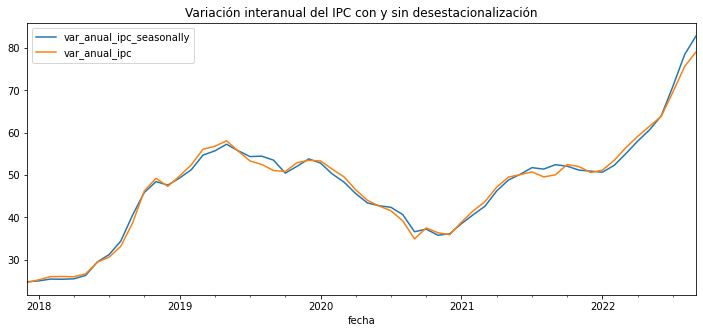

In [38]:
ipc_va.plot(figsize=(12,5))
plt.title('Variación interanual del IPC con y sin desestacionalización')
plt.show()

Para identificar la serie *ARMA (p,q)* necesitamos que la serie sea estacionaria en media y así poder ver como varía alrededor de una media estable a lo largo del tiempo (e idealmente que la varianza sea constante, pero ese problema lo dejamos para otro notebook). Sometemos la serie al test de Dickey-Fuller el cual nos indica si la misma tiene raíz unitaria, o sea si está integrada. Si el valor del *p-value* es mayor que 0.05, no podemos rechazar la hipótesis nula. Esto significa que la serie no es estacionaria (o esta integrada).

In [39]:
print('t-statics:',adfuller(ipc_va['var_anual_ipc'])[0],' p-value:',adfuller(ipc_va['var_anual_ipc'])[1])

t-statics: -0.7828952298856501  p-value: 0.8240949043384386


Vemos que la serie diferenciada si es estacionaria en media.

In [40]:
print('t-statics:',adfuller(ipc_va_diff)[0],' p-value:',adfuller(ipc_va_diff)[1])

t-statics: -3.5360794972087417  p-value: 0.007107426614589408


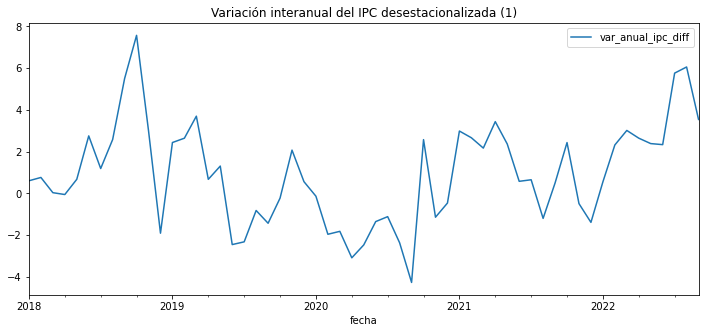

In [41]:
ipc_va_diff.plot(figsize=(12,5))
plt.title('Variación interanual del IPC desestacionalizada (1)')
plt.show()


Para ver si los *lags* de la serie son aleatorios o realmente tienen estructura y la serie depende de su pasado, miramos el *autocorrelation_plot()*, intuitivamente nos dice que el/los primeros lags son significativos, el resto no.  

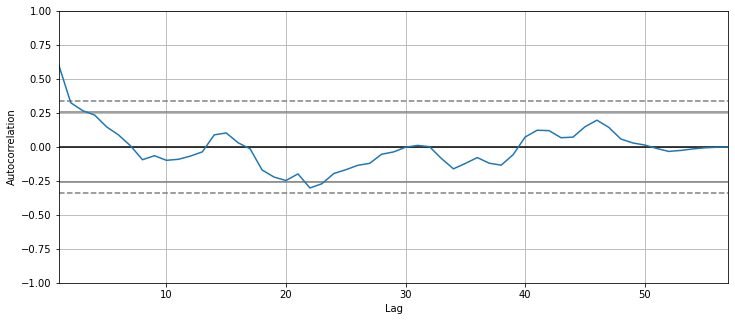

In [42]:
plt.rcParams["figure.figsize"] = (12,5)
autocorrelation_plot(ipc_va_diff) #.set_xlim([0, 50]) # si queremos limitar los lags del gráfico
plt.show()

Vamos entonces a graficar las funciones de Autocorrelacion y de Autocorrelación Parcial para indentificar los *lags* significativos de autorregresivadad y media movil. Para identificar la serie vamos a mirar los ACF y PACF y establecer los grados *p* y *q* en base a lo siguiente:

|      |  AR(p)                      |  MA(p)                       | ARMA(p,q)        |
|------|:---------------------------:|----------------------------:|-----------------:|
| ACF  | Caída sinusoidal            | Significativo hasta orden q | Caída sinusoidal |
| PACF | Significativo hasta orden p | Caída sinusoidal            | Caída sinusoidal |


Dado lo que muestran el ACF y PACF vamos a ver como queda el modelo AR(1). Muchas veces se da que por más que se desestacionalice la serie, quedan significativos los rezagos estacionales y hay que incluirlos como parámetros de la ecuación ARMA (p,q). No es el caso esta vez.


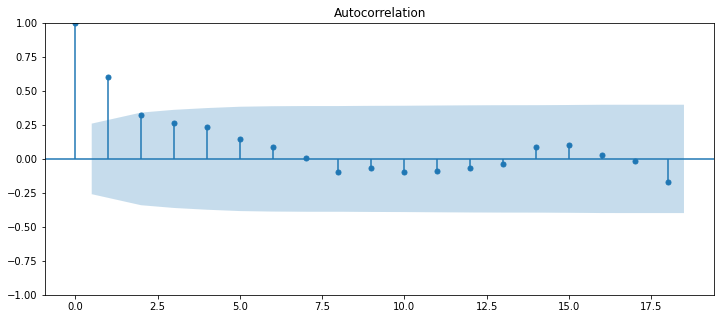

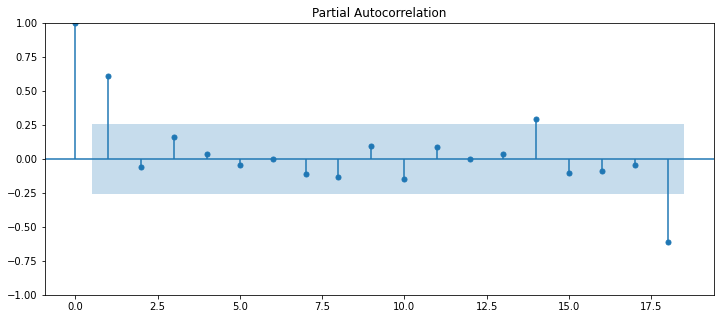

In [43]:
plot_acf(ipc_va_diff);
plot_pacf(ipc_va_diff);
plt.rcParams.figsize= (12,5) 

Los parámetros de la ecuación estimada son significativos, ademas el coeficiente AR es < 1.

In [44]:
model = ARIMA(ipc_va_diff,order=(1,0,0))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:     var_anual_ipc_diff   No. Observations:                   57
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -118.369
Date:                Fri, 11 Nov 2022   AIC                            242.739
Time:                        13:21:53   BIC                            248.868
Sample:                    01-01-2018   HQIC                           245.121
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0142      0.654      1.550      0.121      -0.268       2.296
ar.L1          0.6034      0.089      6.795      0.000       0.429       0.777
sigma2         3.6969      0.747      4.948      0.0

Evaluamos la estiamción: 
- gráfico arriba a la izquierda: Residuos estandarizados a lo largo del tiempo.
- gráfico arriba a la derecha: Histograma más densidad estimada de residuos
- estandarizados, ademas se incluye una densidad Normal(0,1) como referencia.
- gráfico abajo a la izquierda: QQPlot de los residuos.
- gráfico abajo a la derecha: Correlograma de los residuos.

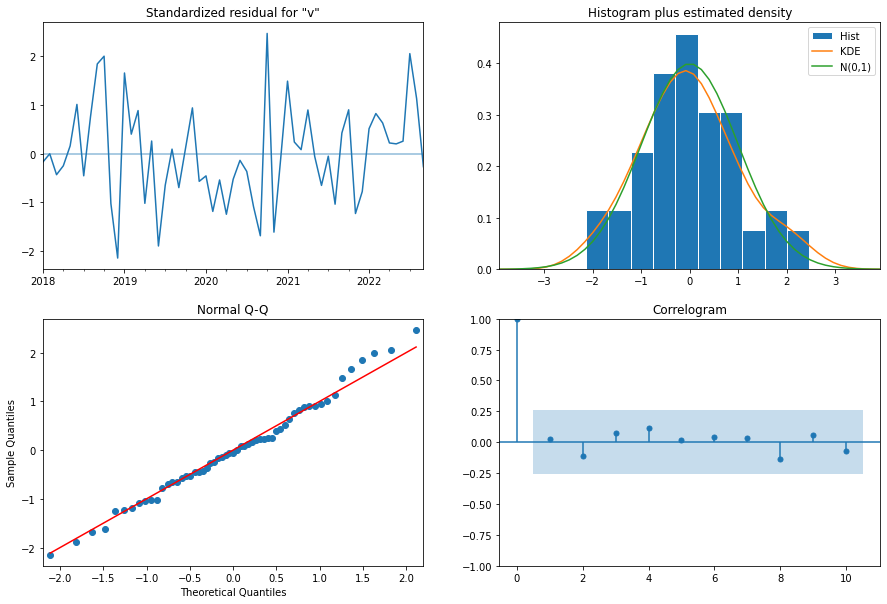

In [45]:
model.plot_diagnostics(figsize = (15, 10))
plt.show()

LM-test-Pvalue: 0.65481


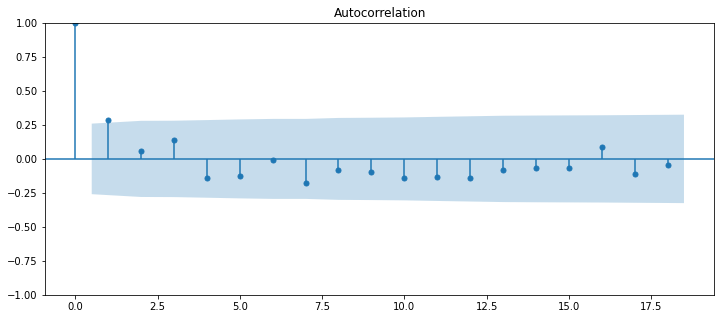

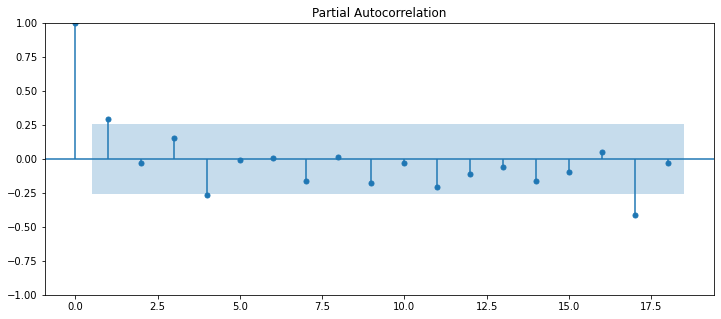

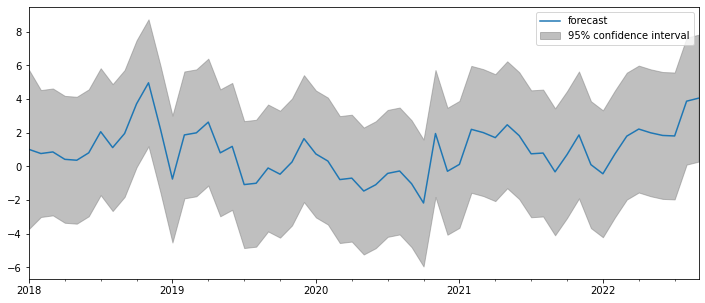

In [46]:
# Te dejo algunos test adicionales que podes hacer para verificar que la serie este bien identificada

arima_resid = model.resid
white_noise_arima = acorr_ljungbox(arima_resid, lags = [10], return_df=True)
white_noise_arima


from statsmodels.stats.diagnostic import het_arch
LM_pvalue = het_arch(arima_resid, ddof = 4)[1]
print('LM-test-Pvalue:', '{:.5f}'.format(LM_pvalue))

plot_acf(arima_resid**2);
plot_pacf(arima_resid**2);
plt.rcParams.figsize= (12,5) 

plot_predict(model)#,dynamic=False
plt.rcParams.figsize= (12,5) 
plt.show()

Te dejo una predicción sobre toda la serie temporal. En el gráfico se ve que la predicción en cierta medida sigue la tendencia, es mas o menos aceptable.

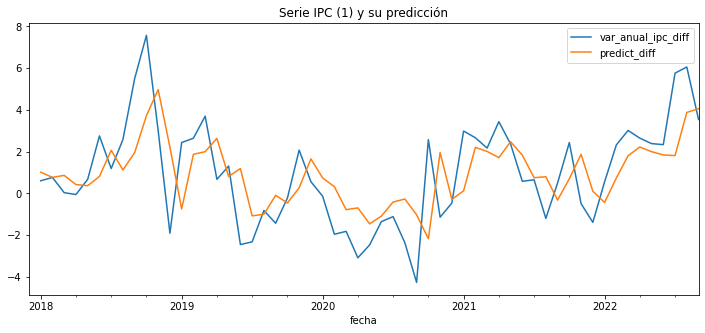

In [47]:
pred_insample = model.get_prediction(start = ipc_va_diff.index.min() , end = ipc_va_diff.index.max())
pred_insample = pd.Series(pred_insample.predicted_mean).to_frame()
pred_insample.columns = ['predict_diff']
# print(pred.conf_int(alpha=0.05))  # Para ver los intervalos de confianza
ipc_va_diff=ipc_va_diff.merge(pred_insample,how='left',right_index=True,left_index=True)
ipc_va = ipc_va.merge(ipc_va_diff,how='left',right_index=True,left_index=True)

# Para integrar la serie predicha 

# ipc_va['predict_diff'][0] = ipc_va['var_anual_ipc'][0]
# ipc_va['predic_va'] = ipc_va['predict_diff'].cumsum()

ipc_va[['var_anual_ipc_diff','predict_diff']].plot()
plt.title('Serie IPC (1) y su predicción')
plt.show()

Ahora vamos a predecir dos valores para adelante en la serie temporal.

In [48]:
pred_outsample = pd.Series(model.forecast(2))
pred_outsample = pd.Series(pred_outsample).to_frame()
pred_outsample.columns = ['predict_diff']
ipc_va_out_sample = ipc_va.copy()
pred_outsample['var_anual_ipc'] = ''
pred_outsample['var_anual_ipc_diff'] = ''
# pred_outsample['predic_va'] = ''
pred_outsample= pred_outsample[['var_anual_ipc','var_anual_ipc_diff','predict_diff']]#,'predic_va']]
ipc_va_out_sample = pd.concat([ipc_va_out_sample,pred_outsample],axis=0,)
# ipc_va_out_sample['predict_diff'][0] = ipc_va_out_sample['var_anual_ipc'][0]
# ipc_va_out_sample['predic_va'] = ipc_va_out_sample['predict_diff'].cumsum()

# Reemplazo los valores vacios de la tabla por NaN

import re
for i in ipc_va_out_sample.columns:
    ipc_va_out_sample[i][ipc_va_out_sample[i].apply(lambda i: True if re.search('^\s*$', str(i)) else False)]=None


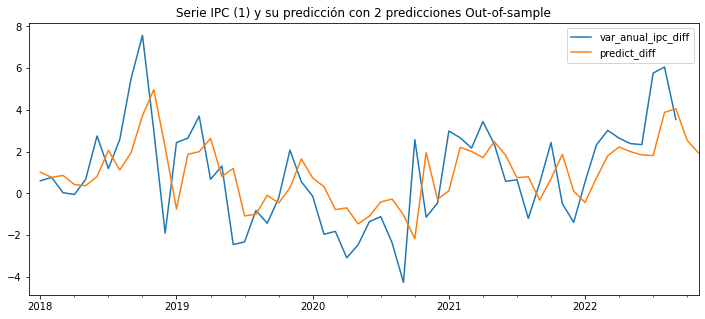

In [49]:
ipc_va_out_sample[['var_anual_ipc_diff','predict_diff']].plot()
plt.title('Serie IPC (1) y su predicción con 2 predicciones Out-of-sample')
plt.show()

Hasta aca tenemos la serie bien identificada, ahora vamos a ver cómo se relaciona la serie con el valor del USD. Primero tiramos las correlaciones, después vemos los gráficos.

Ya los gráficos intuitivamente nos dan un par de *insights* interesantes:
-   La brecha entre el dolar oficial y el blue comienza en el segundo semestre del 2019, a partir de cuando se dieron algunas inestabilidades y endurecieron los cepos.
-   A partir de mediados del 2019 la variabilidad (o volatilidad) del dolar blue crece significativamente (prestar atención a las escalas!!). Hasta mediadios del 2019 las series del dolar son iguales.

In [50]:
ipc_va_dolar[['var_anual_ipc','oficial','blue','ma30_oficial','ma30_blue']].corr(method='pearson')

,var_anual_ipc,oficial,blue,ma30_oficial,ma30_blue
var_anual_ipc,1.000000,0.658944,0.578609,0.656635,0.573672
oficial,0.658944,1.000000,0.978749,0.999394,0.980246
blue,0.578609,0.978749,1.000000,0.977032,0.995028
ma30_oficial,0.656635,0.999394,0.977032,1.000000,0.979271
ma30_blue,0.573672,0.980246,0.995028,0.979271,1.000000


In [51]:
ipc_va_dolar[['var_anual_ipc_diff','oficial_diff','blue_diff','ma30_oficial_diff','ma30_blue_diff']].corr(method='pearson')

,var_anual_ipc_diff,oficial_diff,blue_diff,ma30_oficial_diff,ma30_blue_diff
var_anual_ipc_diff,1.000000,0.299846,0.102561,0.357645,0.120797
oficial_diff,0.299846,1.000000,0.281898,0.790582,0.311547
blue_diff,0.102561,0.281898,1.000000,0.173912,0.539780
ma30_oficial_diff,0.357645,0.790582,0.173912,1.000000,0.361838
ma30_blue_diff,0.120797,0.311547,0.539780,0.361838,1.000000


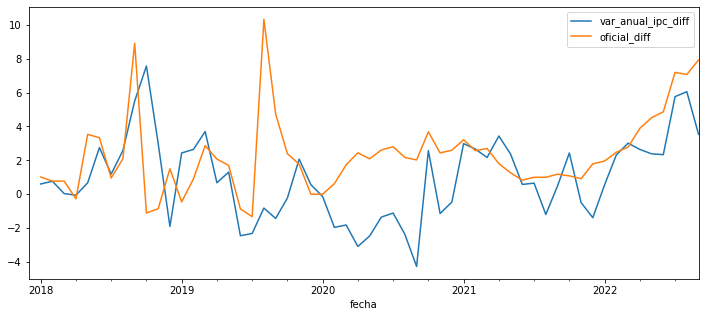

In [52]:
ipc_va_dolar[['var_anual_ipc_diff','oficial_diff']].plot(figsize=(12,5))
plt.show()

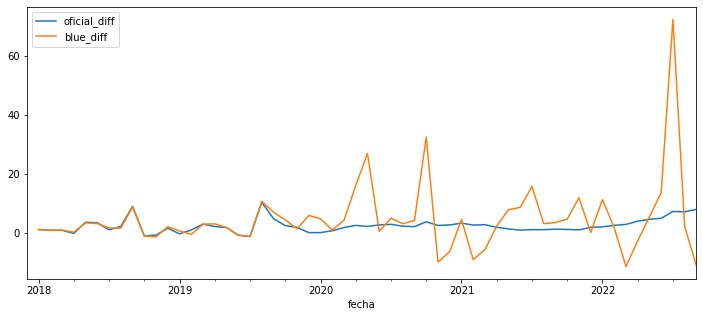

In [53]:
ipc_va_dolar[['oficial_diff','blue_diff']].plot(figsize=(12,5))
plt.show()

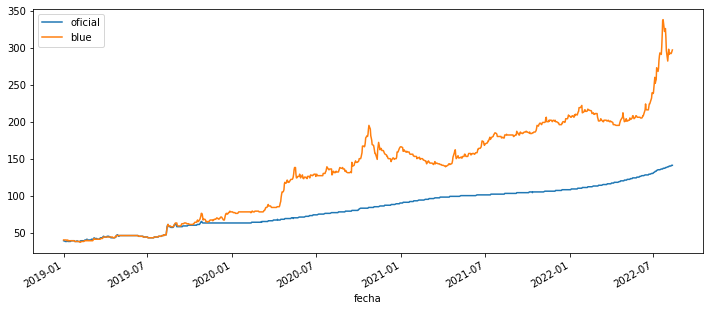

In [63]:
dolar[['oficial','blue']].loc['2019-01-01':'2022-08-11'].plot(figsize=(12,5))
plt.show()

Debajo el test de causalidad de Granger para el dolar *blue* y oficial. En lineas generales se da que la primer diferencia de la media movil 30 días para el dolar *blue* es la variable que podría servir como predictora del IPC, sin embargo no llega a ser del todo siginificativa.

La hipótesis nula del test establece que la serie a utilizar para predecir no "*Granger causa*" la serie original.
Si los *p-values* son inferiores a 0.05, se rechaza la hipótesis nula y concluye que la serie en estudio causa a la original.

El experimento se puede seguir utilizando la brecha o modificando los valores de media movil para el dolar.

In [55]:
grangercausalitytests(ipc_va_dolar[['var_anual_ipc_diff', 'ma30_blue_diff']][1:], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2743  , p=0.6026  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=0.2899  , p=0.5903  , df=1
likelihood ratio test: chi2=0.2891  , p=0.5908  , df=1
parameter F test:         F=0.2743  , p=0.6026  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2571  , p=0.7743  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=0.5657  , p=0.7536  , df=2
likelihood ratio test: chi2=0.5628  , p=0.7547  , df=2
parameter F test:         F=0.2571  , p=0.7743  , df_denom=50, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1291  , p=0.3469  , df_denom=47, df_num=3
ssr based chi2 test:   chi2=3.8918  , p=0.2734  , df=3
likelihood ratio test: chi2=3.7580  , p=0.2888  , df=3
parameter F test:         F=1.1291  , p=0.3469  , df_denom=47, df_num=3


{1: ({'ssr_ftest': (0.27434858505250215, 0.6026130078346464, 53.0, 1),
   'ssr_chi2test': (0.28987775024415324, 0.5902988814322014, 1),
   'lrtest': (0.2891300694136021, 0.5907785422355751, 1),
   'params_ftest': (0.2743485850524909, 0.6026130078346503, 53.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2571454627332613, 0.7742720463589556, 50.0, 2),
   'ssr_chi2test': (0.5657200180131748, 0.7536252812272641, 2),
   'lrtest': (0.5628303693396788, 0.7547149243562714, 2),
   'params_ftest': (0.2571454627332639, 0.7742720463589556, 50.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.129113091590221, 0.3469294131501592, 47.0, 3),
   'ssr_chi2test': (3.891836613566294, 0.27338318464602535, 3),
   'lrtest': (3.7579861949962776, 0.288811007958477, 3),
   'params_ftest': (1.129113091590217, 0.3469294131501592, 47.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0.,

In [56]:
grangercausalitytests(ipc_va_dolar[['var_anual_ipc_diff', 'ma30_oficial_diff']][1:], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4330  , p=0.1248  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=2.5707  , p=0.1089  , df=1
likelihood ratio test: chi2=2.5134  , p=0.1129  , df=1
parameter F test:         F=2.4330  , p=0.1248  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1339  , p=0.3299  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=2.4946  , p=0.2873  , df=2
likelihood ratio test: chi2=2.4397  , p=0.2953  , df=2
parameter F test:         F=1.1339  , p=0.3299  , df_denom=50, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3151  , p=0.2806  , df_denom=47, df_num=3
ssr based chi2 test:   chi2=4.5328  , p=0.2094  , df=3
likelihood ratio test: chi2=4.3526  , p=0.2258  , df=3
parameter F test:         F=1.3151  , p=0.2806  , df_denom=47, df_num=3


{1: ({'ssr_ftest': (2.4329508721606716, 0.12476097172110234, 53.0, 1),
   'ssr_chi2test': (2.570665072471653, 0.10886195525123814, 1),
   'lrtest': (2.5134079305935586, 0.11288158464112752, 1),
   'params_ftest': (2.4329508721606814, 0.12476097172110251, 53.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.1338981077539385, 0.32990992335384134, 50.0, 2),
   'ssr_chi2test': (2.494575837058665, 0.28728287584088263, 2),
   'lrtest': (2.4396583668944345, 0.29528060143080725, 2),
   'params_ftest': (1.133898107753945, 0.3299099233538388, 50.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.3150764464551736, 0.28064106042967507, 47.0, 3),
   'ssr_chi2test': (4.532816687781662, 0.20938172569171504, 3),
   'lrtest': (4.352590048201648, 0.22582185644097522, 3),
   'params_ftest': (1.3150764464551694, 0.280641060429676, 47.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

In [57]:
grangercausalitytests(ipc_va_dolar[['var_anual_ipc_diff', 'ma30_oficial']][1:], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4679  , p=0.4970  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=0.4943  , p=0.4820  , df=1
likelihood ratio test: chi2=0.4922  , p=0.4830  , df=1
parameter F test:         F=0.4679  , p=0.4970  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1834  , p=0.3147  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=2.6036  , p=0.2720  , df=2
likelihood ratio test: chi2=2.5438  , p=0.2803  , df=2
parameter F test:         F=1.1834  , p=0.3147  , df_denom=50, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3009  , p=0.2852  , df_denom=47, df_num=3
ssr based chi2 test:   chi2=4.4841  , p=0.2137  , df=3
likelihood ratio test: chi2=4.3076  , p=0.2301  , df=3
parameter F test:         F=1.3009  , p=0.2852  , df_denom=47, df_num=3


{1: ({'ssr_ftest': (0.46785637872398206, 0.49695491562485583, 53.0, 1),
   'ssr_chi2test': (0.4943388152555282, 0.4819982158497952, 1),
   'lrtest': (0.49216968847287035, 0.48296104926462013, 1),
   'params_ftest': (0.46785637872399444, 0.4969549156248504, 53.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.1834429225543963, 0.31465265995697855, 50.0, 2),
   'ssr_chi2test': (2.603574429619672, 0.2720451551700821, 2),
   'lrtest': (2.5438290137569197, 0.28029448204971513, 2),
   'params_ftest': (1.1834429225543013, 0.31465265995700625, 50.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.300936022260867, 0.2852285601720981, 47.0, 3),
   'ssr_chi2test': (4.484077353324691, 0.21371495592587095, 3),
   'lrtest': (4.307606386065629, 0.23010684143099228, 3),
   'params_ftest': (1.3009360222604776, 0.2852285601722256, 47.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

In [58]:
grangercausalitytests(ipc_va_dolar[['var_anual_ipc_diff', 'ma30_blue']][1:], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6806  , p=0.4131  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=0.7192  , p=0.3964  , df=1
likelihood ratio test: chi2=0.7146  , p=0.3979  , df=1
parameter F test:         F=0.6806  , p=0.4131  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7506  , p=0.4773  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=1.6514  , p=0.4379  , df=2
likelihood ratio test: chi2=1.6271  , p=0.4433  , df=2
parameter F test:         F=0.7506  , p=0.4773  , df_denom=50, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4504  , p=0.7182  , df_denom=47, df_num=3
ssr based chi2 test:   chi2=1.5524  , p=0.6702  , df=3
likelihood ratio test: chi2=1.5305  , p=0.6752  , df=3
parameter F test:         F=0.4504  , p=0.7182  , df_denom=47, df_num=3


{1: ({'ssr_ftest': (0.6806317867402654, 0.41306713708191567, 53.0, 1),
   'ssr_chi2test': (0.7191581142916011, 0.39642020182584337, 1),
   'lrtest': (0.7145795183338635, 0.3979277019940889, 1),
   'params_ftest': (0.680631786740268, 0.41306713708191367, 53.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.7506185377401969, 0.4773188461168717, 50.0, 2),
   'ssr_chi2test': (1.6513607830284331, 0.4379369225084768, 2),
   'lrtest': (1.6270552559888642, 0.44329153714540925, 2),
   'params_ftest': (0.7506185377401754, 0.47731884611688113, 50.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.45039757676005154, 0.7182049225105287, 47.0, 3),
   'ssr_chi2test': (1.5524342007474117, 0.6702224722958761, 3),
   'lrtest': (1.5305375820644826, 0.6752404177022642, 3),
   'params_ftest': (0.45039757676003656, 0.7182049225105389, 47.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

Modelo y predicción utilizando el dolar *blue*

In [59]:
model2 = sm.tsa.statespace.SARIMAX(ipc_va_dolar['var_anual_ipc_diff'][1:], ipc_va_dolar['ma30_blue_diff'][1:], order=(1,0,0))
model2 = model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:     var_anual_ipc_diff   No. Observations:                   57
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -118.078
Date:                Fri, 11 Nov 2022   AIC                            242.157
Time:                        13:21:58   BIC                            248.286
Sample:                    01-01-2018   HQIC                           244.539
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ma30_blue_diff     0.0446      0.028      1.571      0.116      -0.011       0.100
ar.L1              0.6531      0.088      7.406      0.000       0.480       0.826
sigma2             3.6527      0.800

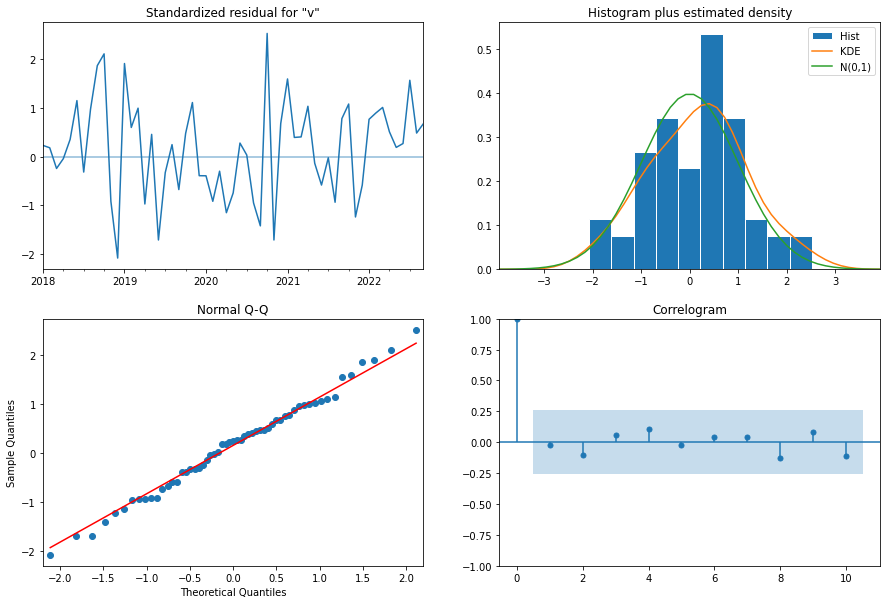

In [60]:
model2.plot_diagnostics(figsize = (15, 10))
plt.show()

El gráfico muestra que la prediccion que incluye a la media movil 30 días del dolar blue como predictor es muy parecida a la que no lo incluye.

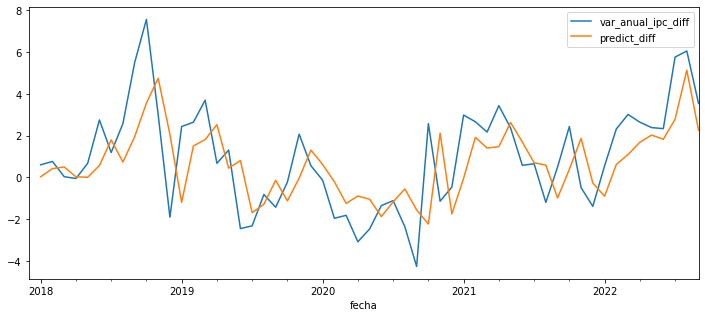

In [61]:
pred_insample2 = model2.get_prediction(start = ipc_va_dolar[1:].index.min() , end = ipc_va_dolar[1:].index.max())
pred_insample2 = pd.Series(pred_insample2.predicted_mean).to_frame()
pred_insample2.columns = ['predict_diff']

ipc_va_dolar = ipc_va_dolar.merge(pred_insample2,how='left',right_index=True,left_index=True)

ipc_va_dolar[['var_anual_ipc_diff','predict_diff']].plot()
plt.show()

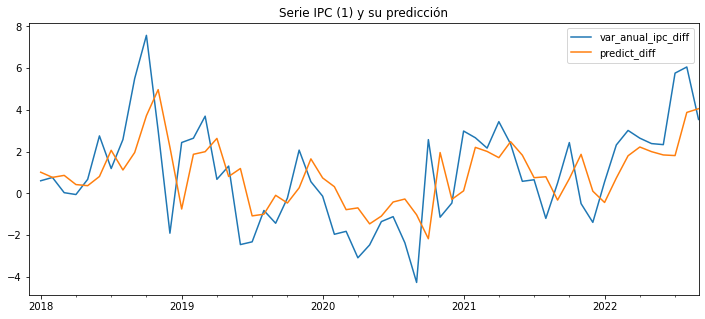

In [62]:
ipc_va_out_sample[['var_anual_ipc_diff','predict_diff']][:-2].plot() # [:-2] es para no incluir las predicciones out-of-sample que hicimos antes
plt.title('Serie IPC (1) y su predicción')
plt.show()